In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

def exp_func(x, a, b, c):
    return -a*np.exp(-b*x) + c
def exp_func2(x, a, b, c, d):
    return a*np.exp(b*(x-c)) + d
def saturation_cuve(t, tau, a0):
    return a0*(1 - np.exp(-t / tau))
def stretched_saturation_curve(t, tau, a0, beta):
    return a0*(1 - np.exp(-((t/tau)**beta)))
def double_saturation_cuve(t, tau1, tau2, a0, b0, b1):
    return a0 - b0* np.exp(-t / tau1) - b1* np.exp(-t / tau2)
def lin_func(x, a, b, c):
    return a*(x-b)+c
def pot_law(x, a, b):
    return a*x**b
def double_saturation_cuve(t, tau1, tau2, a0, b0, b1):
    return a0 - b0* np.exp(-t / tau1) - b1* np.exp(-t / tau2)

## DC Input - Voltage Distribution - Closed Circuit

In [246]:
# folder_cold = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
# folder_hot  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
folder_cold = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
folder_hot  = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 40000
U_0_cold    = 0.02
U_0_hot     = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20]
pot_cold    = {N_p : pd.read_csv(f"{folder_cold}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_hot     = {N_p : pd.read_csv(f"{folder_hot}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq_cold = pd.DataFrame([pot_cold[N_p].iloc[38000:,:].mean().values / U_0_cold for N_p in N_vals],index=N_vals).T.round(2)
pot_eq_hot  = pd.DataFrame([pot_hot[N_p].iloc[38000:,:].mean().values / U_0_hot for N_p in N_vals],index=N_vals).T.round(2)

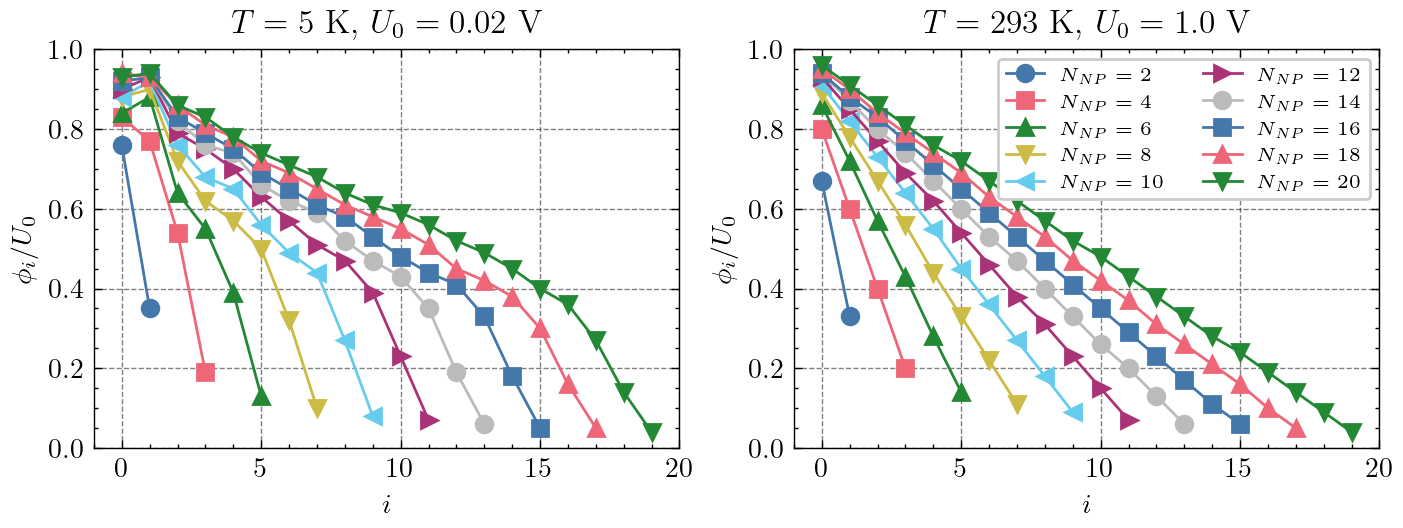

In [249]:
ma  = ["o","s","^","v","<",">"]
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):
    ax1.plot(pot_eq_cold[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")
    ax2.plot(pot_eq_hot[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax1.set_xlim(-1,20)
ax2.set_xlim(-1,20)
ax1.set_ylabel("$\phi_i / U_0$")
ax2.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/closed_circuit_node_potential_vs_T.svg", transparent=True)

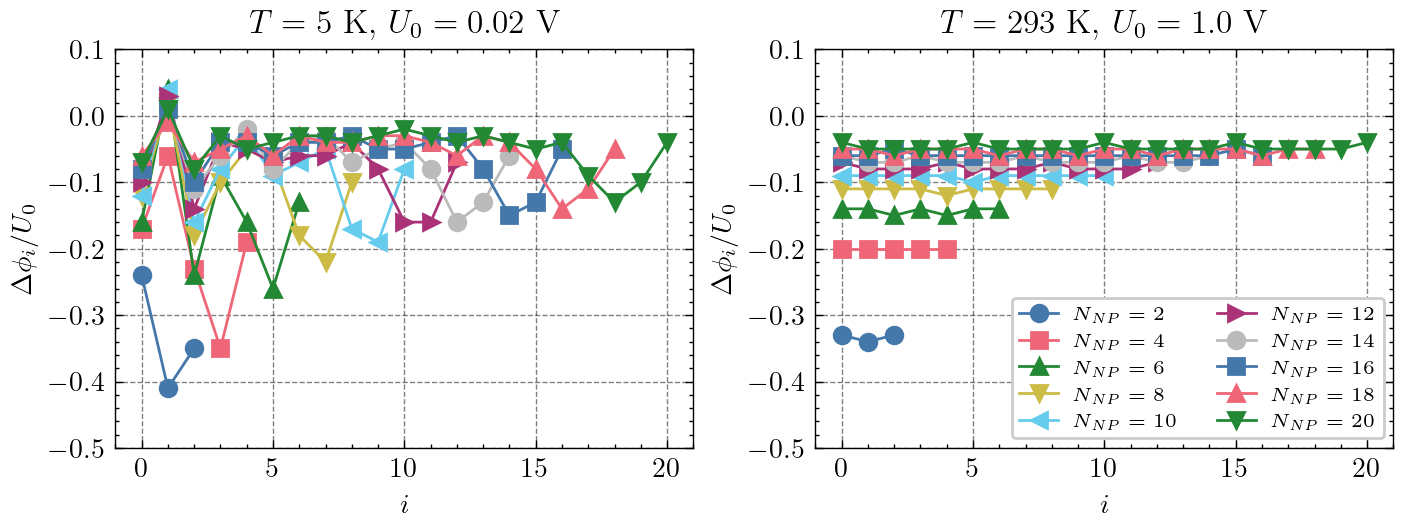

In [250]:
ma  = ["o","s","^","v","<",">"]
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):

    arr_cold    = np.insert(pot_eq_cold[N].dropna().values*U_0_cold, 0, U_0_cold)
    arr_cold    = np.append(arr_cold, 0.0)
    arr_cold    = np.diff(arr_cold)

    arr_hot = np.insert(pot_eq_hot[N].dropna().values*U_0_hot, 0, U_0_hot)
    arr_hot = np.append(arr_hot, 0.0)
    arr_hot = np.diff(arr_hot)

    ax1.plot(arr_cold/U_0_cold, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")
    ax2.plot(arr_hot/U_0_hot, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$")

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlim(-1,21)
ax2.set_xlim(-1,21)
ax1.set_ylim(-0.5, 0.1)
ax2.set_ylim(-0.5, 0.1)
ax1.set_ylabel("$\Delta \phi_i / U_0$")
ax2.set_ylabel("$\Delta \phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/closed_circuit_node_potential_difference_vs_T.svg", transparent=True)

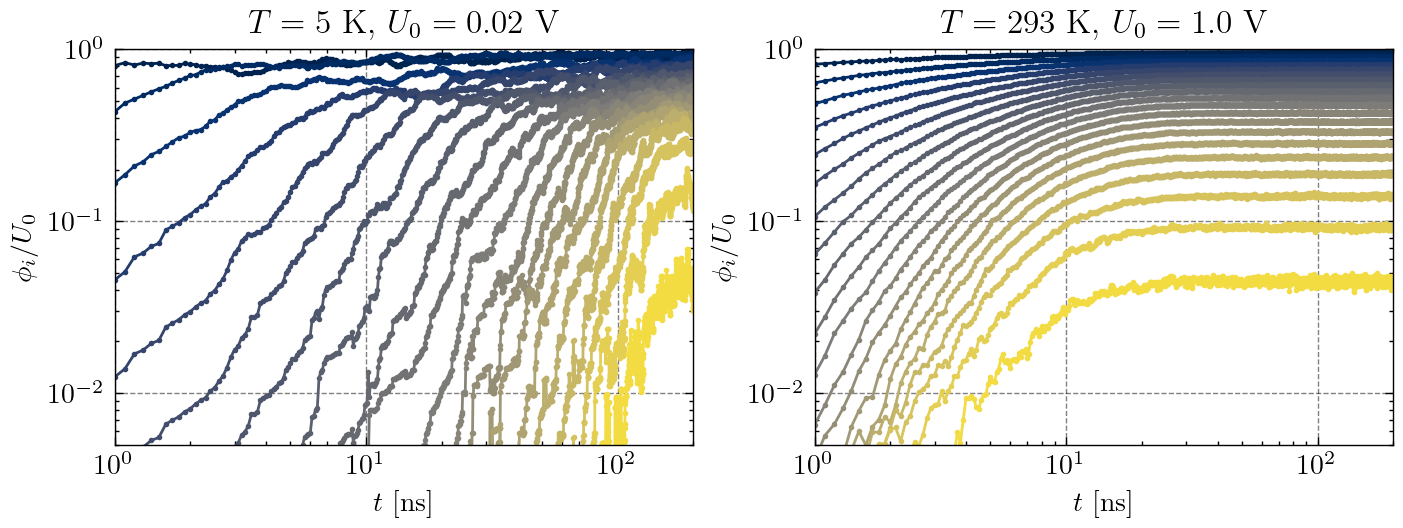

In [192]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
cm  = plt.get_cmap('cividis')
Np  = 20

for i in range(Np):
    ax1.plot(t_vals, pot_cold[Np][f"{i}"].values/U_0_cold, color=cm((i)/Np), marker='.', ms=2)
    p = ax2.plot(t_vals, pot_hot[Np][f"{i}"].values/U_0_hot, color=cm((i)/Np), marker='.', ms=2)

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlabel("$t$ [ns]")
ax1.set_xlim(1,200)
ax2.set_xlim(1,200)
ax1.set_ylim(0.005,1)
ax2.set_ylim(0.005,1)
# ax1.set_xlim(0,50)
# ax2.set_xlim(0,50)
# ax1.set_ylim(0,1)
# ax2.set_ylim(0,1)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$t$ [ns]")
ax2.set_ylabel("$\phi_i / U_0$")
ax2.set_xlabel("$t$ [ns]")

fig.savefig("../plots/dc_input/closed_circuit_node_time_series_vs_T.svg", transparent=True)

In [251]:
end_vals    = pot_hot[Np].iloc[38000:,:].mean().values
taus        = []
p_th        = 0.63
for i in range(Np):
    j   = np.argwhere(pot_hot[Np].loc[:,f'{i}'].values > p_th*end_vals[i])[0,0]
    tau = t_vals[j]
    taus.append(tau)

(-1.0, 20.0)

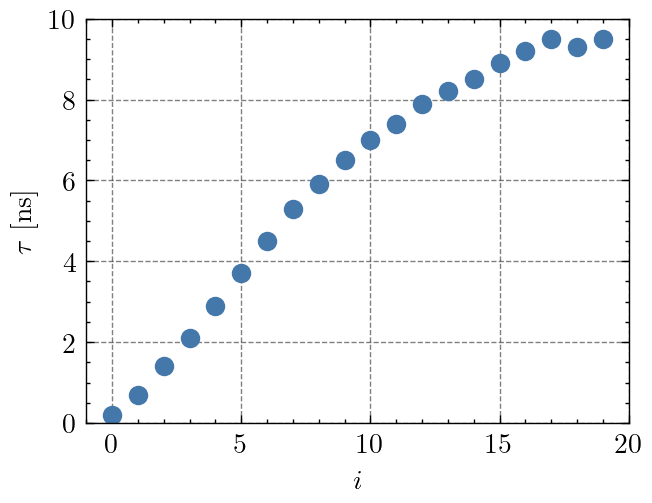

In [252]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(range(Np), taus, 'o')
ax.set_xlabel("$i$")
ax.set_ylabel("$\\tau$ [ns]")
ax.set_ylim(0,10)
ax.set_xlim(-1,20)

In [253]:
pot_hot[Np]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.396231,0.148915,0.055510,0.018459,0.005967,0.002310,0.000669,0.000213,0.000740,0.000809,0.000692,-0.000947,-0.000317,-0.001924,-0.000351,0.000157,0.000583,0.000904,-0.000685,0.000007
1,0.542939,0.272378,0.126195,0.052293,0.021227,0.007866,0.003752,0.002983,0.000297,-0.000035,-0.000867,-0.001537,-0.001314,-0.001206,0.000550,0.000722,0.000341,-0.000341,-0.000258,-0.000028
2,0.625489,0.361915,0.192573,0.093644,0.044242,0.018353,0.007950,0.004515,0.002051,0.001207,-0.002278,-0.003662,-0.001932,-0.001413,0.001362,0.001472,0.001483,-0.000651,-0.002152,0.000123
3,0.681934,0.429660,0.249868,0.135492,0.069334,0.030754,0.014270,0.006949,0.005193,0.002395,-0.002806,-0.003068,-0.001763,-0.000543,-0.000160,0.001938,0.001764,-0.000447,-0.001630,0.000772
4,0.720880,0.482974,0.298971,0.176763,0.095167,0.048703,0.022023,0.011069,0.007908,0.002673,-0.002061,-0.000873,-0.001713,-0.000675,0.000291,0.001217,0.000421,0.001917,-0.000157,0.001564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39994,0.955173,0.910042,0.860668,0.811229,0.764452,0.715124,0.667801,0.620097,0.569379,0.523667,0.473330,0.427108,0.380985,0.333752,0.283096,0.237198,0.191861,0.143064,0.093095,0.044310
39995,0.954359,0.908714,0.862016,0.811503,0.764628,0.714395,0.666150,0.619823,0.571386,0.522598,0.474153,0.427781,0.380671,0.335079,0.282474,0.234995,0.192440,0.143664,0.093201,0.045341
39996,0.953973,0.908808,0.861874,0.810152,0.763120,0.713635,0.668028,0.618512,0.571058,0.524421,0.474753,0.427613,0.378105,0.334037,0.285318,0.236675,0.190776,0.143699,0.093349,0.047422
39997,0.954001,0.907556,0.860719,0.810147,0.763069,0.715508,0.668521,0.618350,0.571682,0.523639,0.475908,0.427664,0.377775,0.331166,0.286158,0.237468,0.192557,0.143898,0.091917,0.047086


In [257]:
p_diff.values

array([[-2.47316371e-01, -9.34055210e-02, -3.70500748e-02, ...,
         3.20758288e-04, -1.58935800e-03,  6.92706329e-04],
       [-2.70560157e-01, -1.46182948e-01, -7.39022772e-02, ...,
        -6.81468023e-04,  8.24911193e-05,  2.30268729e-04],
       [-2.63573704e-01, -1.69342210e-01, -9.89290083e-02, ...,
        -2.13373879e-03, -1.50159459e-03,  2.27528107e-03],
       ...,
       [-4.51646842e-02, -4.69341268e-02, -5.17222991e-02, ...,
        -4.70773758e-02, -5.03503062e-02, -4.59263466e-02],
       [-4.64455113e-02, -4.68365440e-02, -5.05721289e-02, ...,
        -4.86592031e-02, -5.19804947e-02, -4.48316021e-02],
       [-4.69386837e-02, -4.44063433e-02, -4.93521505e-02, ...,
        -4.78067696e-02, -5.23744012e-02, -4.54798418e-02]])

In [263]:
p_diff.shape

(39999, 19)

In [264]:
np.insert(p_diff, 0, np.zeros(Np-1), axis=0)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.47316371e-01, -9.34055210e-02, -3.70500748e-02, ...,
         3.20758288e-04, -1.58935800e-03,  6.92706329e-04],
       [-2.70560157e-01, -1.46182948e-01, -7.39022772e-02, ...,
        -6.81468023e-04,  8.24911193e-05,  2.30268729e-04],
       ...,
       [-4.51646842e-02, -4.69341268e-02, -5.17222991e-02, ...,
        -4.70773758e-02, -5.03503062e-02, -4.59263466e-02],
       [-4.64455113e-02, -4.68365440e-02, -5.05721289e-02, ...,
        -4.86592031e-02, -5.19804947e-02, -4.48316021e-02],
       [-4.69386837e-02, -4.44063433e-02, -4.93521505e-02, ...,
        -4.78067696e-02, -5.23744012e-02, -4.54798418e-02]])

(-1.0, 20.0)

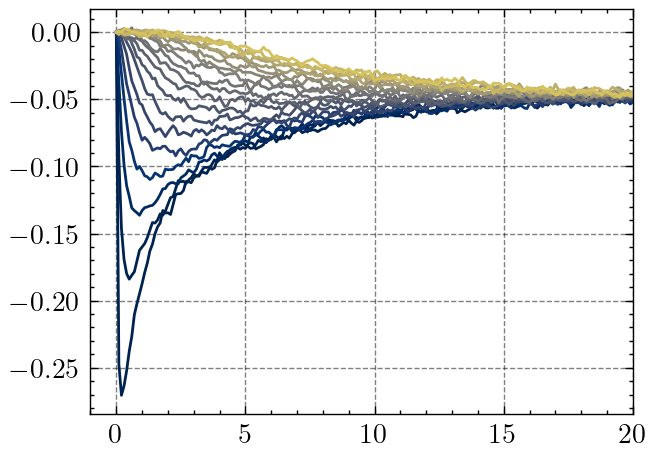

In [267]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_hot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i], color=cm((i-1)/Np))
ax.set_xlim(-1,20)

In [300]:
def exp_recovery(x, A, B, C, D, E):
    return A - B*np.exp(-C*x) + D*np.exp(-E*x)

/tmp/ipykernel_20331/1320662475.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  p, c        = curve_fit(exp_recovery, t_test, arr_test, maxfev=10000)
/tmp/ipykernel_20331/427428941.py:2: RuntimeWarning: overflow encountered in exp
  return A - B*np.exp(-C*x) + D*np.exp(-E*x)
/tmp/ipykernel_20331/427428941.py:2: RuntimeWarning: overflow encountered in multiply
  return A - B*np.exp(-C*x) + D*np.exp(-E*x)
/tmp/ipykernel_20331/427428941.py:2: RuntimeWarning: invalid value encountered in add
  return A - B*np.exp(-C*x) + D*np.exp(-E*x)


(-1.0, 10.0)

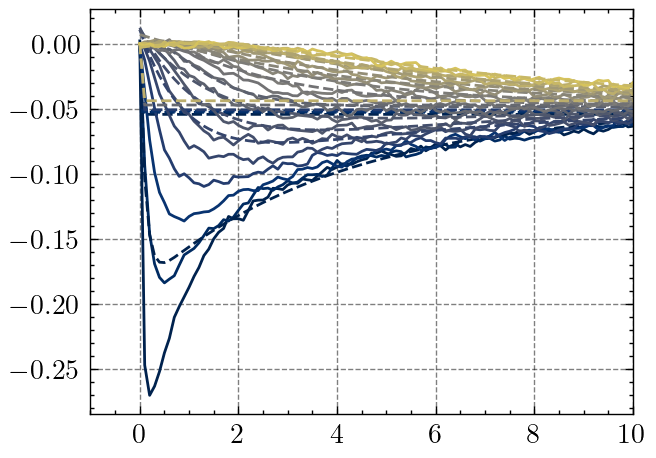

In [303]:
taus    = []
stop    = 1000
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot_hot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()

for np_idx in range(Np-2):
    t_test      = t_f_d.copy()[:stop]
    arr_test    = p_diff[:,np_idx].copy()[:stop]
    p, c        = curve_fit(exp_recovery, t_test, arr_test, maxfev=10000)
    taus.append(1/p[2])

    ax.plot(t_test, arr_test, '-', color=cm((np_idx)/Np))
    ax.plot(t_test, exp_recovery(t_test, *p), '--', color=cm((np_idx-1)/Np))


ax.set_xlim(-1,10)

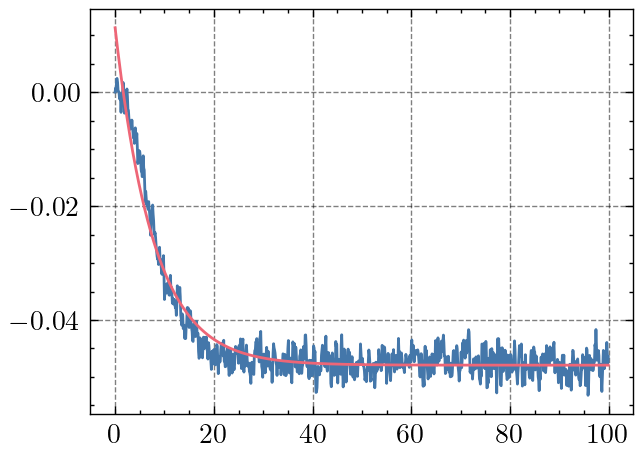

In [285]:
plt.figure(dpi=200)
plt.plot(t_test, arr_test)
plt.plot(t_test, exp_recovery(t_test, *p))

In [215]:
np_idx  = [i//2 for i in N_vals]
taus    = []
p_th    = 0.63
for i, N in enumerate(N_vals):
    signal  = pot_hot[N][f"{np_idx[i]}"].values
    end_val = np.mean(signal[38000:])
    j       = np.where(signal>p_th*end_val)[0][0]
    tau     = t_vals[j]
    taus.append(tau)

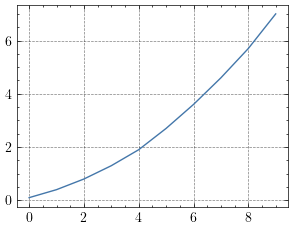

In [217]:
plt.plot(taus)

[0.14029666 0.95695685 0.32925427]
[0.62436528 0.90948404 0.44113213]
[1.34091819 0.86141845 0.54258862]
[2.16758701 0.81243589 0.64558633]
[3.02069569 0.76357518 0.74442006]
[3.85073109 0.71497466 0.84246336]
[4.65082634 0.66649019 0.94204433]
[5.38611491 0.61802147 1.04232542]
[6.0437237  0.56983048 1.13033745]
[6.6421816  0.52166606 1.21224087]
[7.17228976 0.47307969 1.29598181]
[7.65795238 0.42516942 1.37652122]
[8.09492699 0.37738744 1.44462055]
[8.48022098 0.32960101 1.51586038]
[8.82048296 0.28201967 1.58282071]
[9.10848299 0.23435998 1.62480258]
[9.38854195 0.18685138 1.67073325]
[9.49797762 0.13917457 1.69324025]
[9.60829458 0.09190697 1.75384514]
[9.70129306 0.0447039  1.74355597]


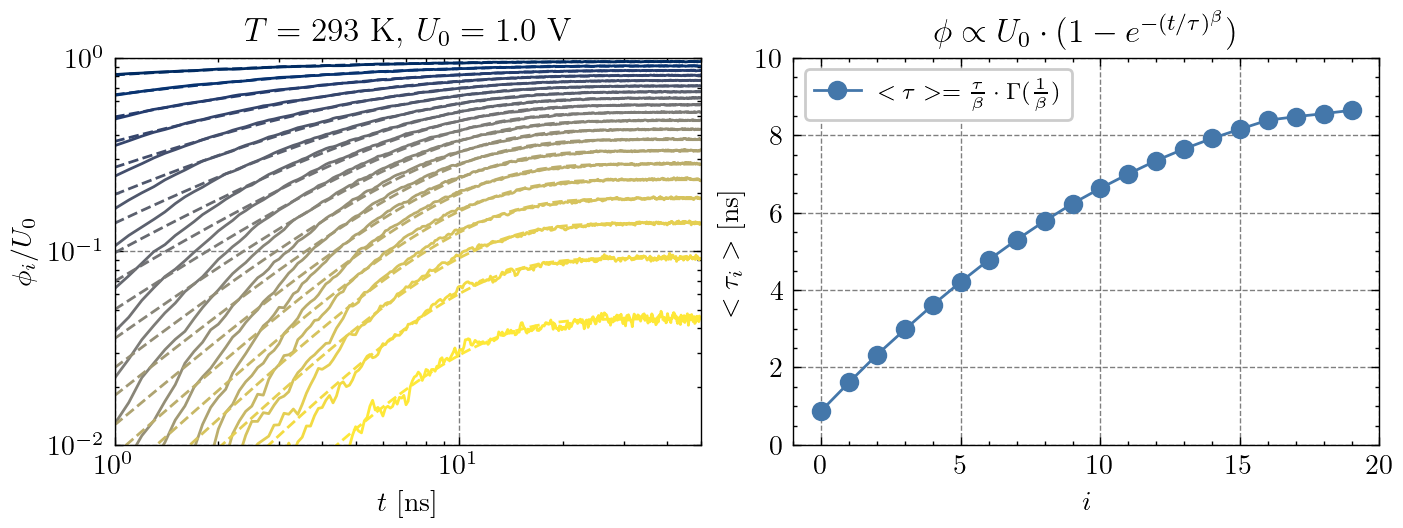

In [173]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax      = fig.add_subplot(1,2,1)
cm      = plt.get_cmap('cividis')
taus    = []
taus1   = []
taus2   = []
betas   = []
starts  = [10,10,10,10,20,20,20,20,30,30,30,30,40,40,40,40,50,50,50,50]
starts  = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]

for i in range(Np):
    x, y    = t_vals[starts[i]:500], pot_hot[Np][f"{i}"].values[starts[i]:500]/U_0_hot
    p,c     = curve_fit(stretched_saturation_curve, x, y, maxfev=10000, p0=[1,1,1], bounds=[(0,0,0),(10,1,2)])#, p0=[1,5,1.0,0.0,0.0], bounds=[(0,0,0,0,0),(10,10,1,2,2)])
    taus.append(p[0])
    taus1.append(p[0])
    taus2.append(p[1])
    betas.append(p[2])
    print(p)

    ax.plot(x, y, color=cm((i+1)/Np), ms=4)#, marker='.')
    ax.plot(x, stretched_saturation_curve(x, *p), color=cm((i+1)/Np), ls='--')

tau = gamma(1/np.array(betas))*np.array(taus)/np.array(betas)
ax.set_xlim(1,50)
# ax.set_ylim(0.001,1)
ax.set_ylim(0.01,1)
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")

ax  = fig.add_subplot(1,2,2)
ax.plot(range(Np), tau, 'o-', label='$<\\tau> = \\frac{\\tau}{\\beta} \cdot \Gamma(\\frac{1}{\\beta})$')
# ax.plot(range(Np), taus1, 'o-', label='$\\tau_1$')
# ax.plot(range(Np), taus2, 'o-', label='$\\tau_2$')
ax.set_ylabel('$<\\tau_i>$ [ns]')
ax.set_xlabel("$i$")
ax.set_ylim(0,10)
ax.set_xlim(-1,20)
ax.set_title("$\phi \propto U_0 \cdot (1 - e^{-(t/\\tau)^{\\beta}})$")
ax.legend(fontsize='small')

fig.savefig("../plots/dc_input/closed_circuit_room_temp_fit.svg", transparent=True)

In [174]:
current_cold    = {N_p : pd.read_csv(f"{folder_cold}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
current_hot     = {N_p : pd.read_csv(f"{folder_hot}Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}

Text(0.5, 0, '$t$ [ns]')

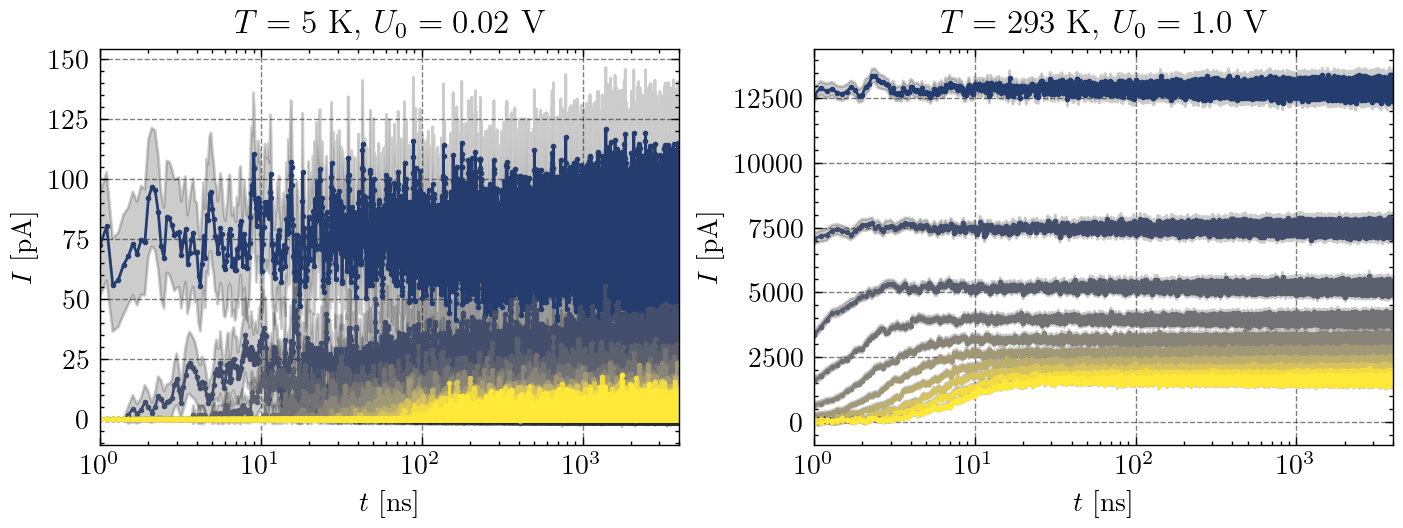

In [178]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
cm  = plt.get_cmap('cividis')
Np  = 20

for i in N_vals:
    ax1.plot(t_vals, current_cold[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)
    ax1.fill_between(t_vals, current_cold[i]['Current'].values-current_cold[i]['Error'].values,
                     current_cold[i]['Current'].values+current_cold[i]['Error'].values, color='black', alpha=0.2)
    ax2.plot(t_vals, current_hot[i]['Current'].values, color=cm((i+1)/Np), marker='.', ms=2)
    ax2.fill_between(t_vals, current_hot[i]['Current'].values-current_hot[i]['Error'].values,
                     current_hot[i]['Current'].values+current_hot[i]['Error'].values, color='black', alpha=0.2)

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlabel("$t$ [ns]")
ax1.set_xlim(1,4000)
ax2.set_xlim(1,4000)
# ax1.set_ylim(0.0001,10000)
# ax2.set_ylim(10,100000)
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylabel("$I$ [pA]")
ax1.set_xlabel("$t$ [ns]")
ax2.set_ylabel("$I$ [pA]")
ax2.set_xlabel("$t$ [ns]")

In [186]:

pot_hot[8]

,0,1,2,3,4,5,6,7
0,0.393197,0.147215,0.052589,0.017786,0.007366,0.001739,0.000727,-0.001291
1,0.546792,0.269609,0.120898,0.052062,0.020414,0.006801,0.003302,0.001312
2,0.630452,0.361773,0.188159,0.091890,0.042138,0.018606,0.007108,0.005518
3,0.683428,0.428687,0.246231,0.136314,0.067556,0.031691,0.014098,0.006539
4,0.725259,0.480466,0.297958,0.176336,0.095430,0.047953,0.022988,0.010162
...,...,...,...,...,...,...,...,...
39994,0.893388,0.779150,0.669557,0.556470,0.443289,0.330028,0.221172,0.109826
39995,0.896476,0.779644,0.669860,0.556805,0.443751,0.330288,0.220478,0.108891
39996,0.894438,0.781247,0.668043,0.556589,0.445506,0.331979,0.220086,0.107086
39997,0.892989,0.781000,0.669687,0.555569,0.445341,0.331954,0.219369,0.108253


## DC Input - Voltage Distribution - Open Circuit

In [135]:
# folder_cold = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
# folder_hot  = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
folder_cold = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size//"
folder_hot  = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
U_0_cold    = 0.02
U_0_hot     = 1.0
t_vals      = np.arange(39999)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20]
pot_cold    = {N_p : pd.read_csv(f"{folder_cold}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_hot     = {N_p : pd.read_csv(f"{folder_hot}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq_cold = pd.DataFrame([pot_cold[N_p].iloc[30000:,:].mean().values / U_0_cold for N_p in N_vals],index=N_vals).T.round(2)
pot_eq_hot  = pd.DataFrame([pot_hot[N_p].iloc[30000:,:].mean().values / U_0_hot for N_p in N_vals],index=N_vals).T.round(2)

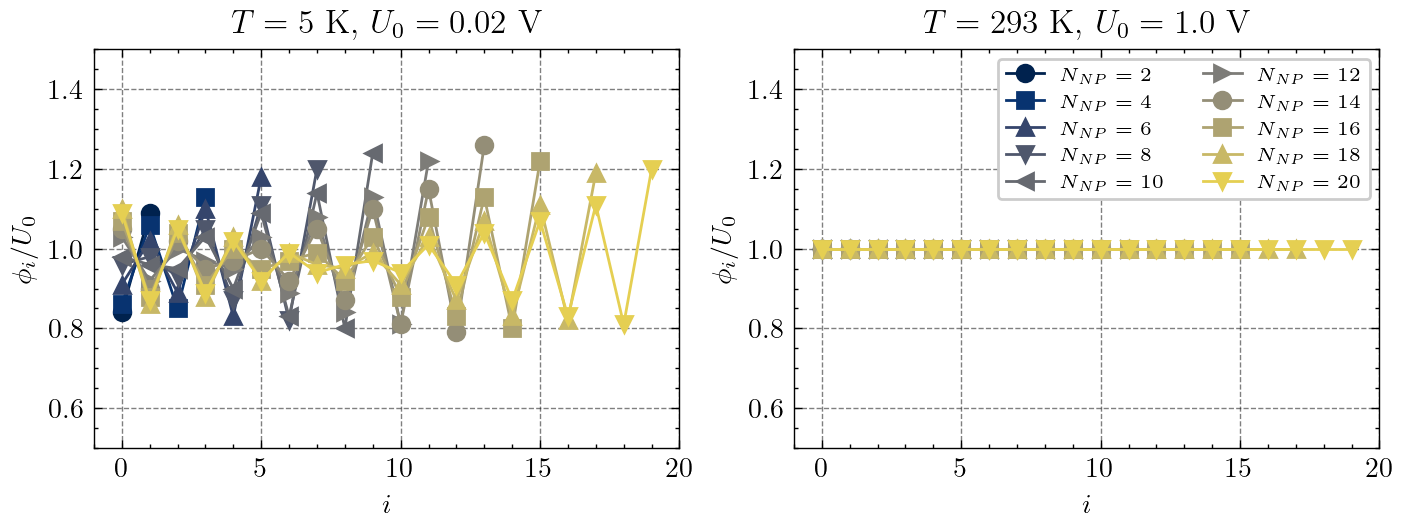

In [136]:
ma  = ["o","s","^","v","<",">"]
cm  = plt.get_cmap('cividis')
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):
    ax1.plot(pot_eq_cold[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))
    ax2.plot(pot_eq_hot[N].values, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_ylim(0.5,1.5)
ax2.set_ylim(0.5,1.5)
ax1.set_xlim(-1,20)
ax2.set_xlim(-1,20)
ax1.set_ylabel("$\phi_i / U_0$")
ax2.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/open_circuit_node_potential_vs_T.svg", transparent=True)

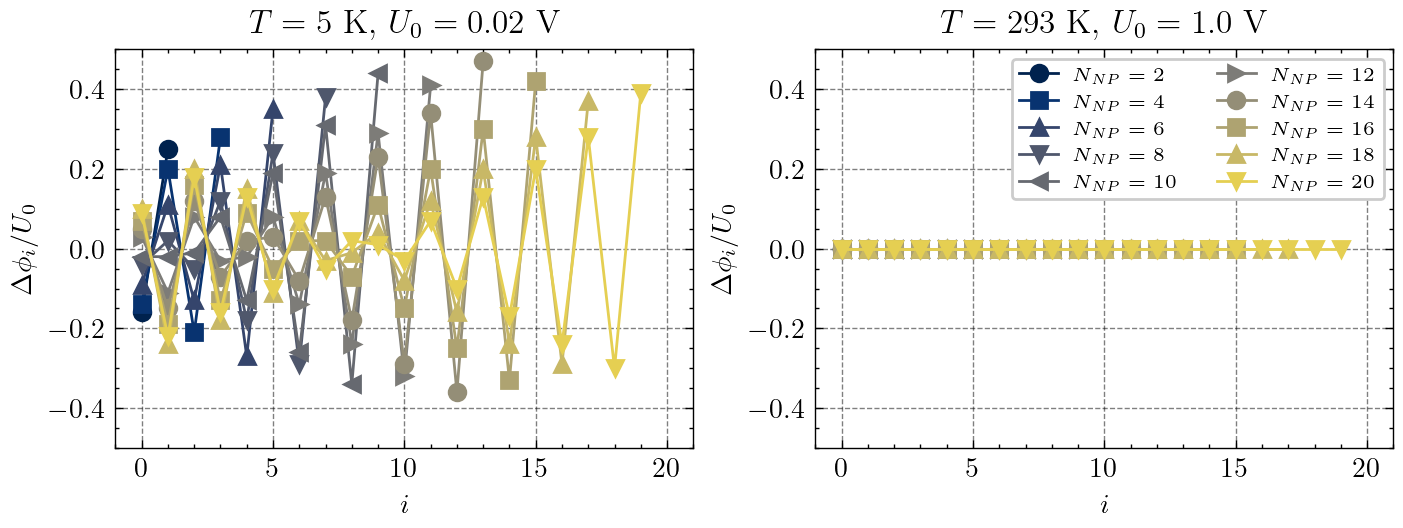

In [137]:
ma  = ["o","s","^","v","<",">"]
cm  = plt.get_cmap('cividis')
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, N in enumerate(N_vals):

    arr_cold    = np.insert(pot_eq_cold[N].dropna().values*U_0_cold, 0, U_0_cold)
    arr_cold    = np.diff(arr_cold)

    arr_hot = np.insert(pot_eq_hot[N].dropna().values*U_0_hot, 0, U_0_hot)
    arr_hot = np.diff(arr_hot)

    ax1.plot(arr_cold/U_0_cold, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))
    ax2.plot(arr_hot/U_0_hot, marker=ma[i%len(ma)], label="$N_{NP} = "+f"{N}$", color=cm((i)/len(N_vals)))

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlim(-1,21)
ax2.set_xlim(-1,21)
ax1.set_ylim(-0.5, 0.5)
ax2.set_ylim(-0.5, 0.5)
ax1.set_ylabel("$\Delta \phi_i / U_0$")
ax2.set_ylabel("$\Delta \phi_i / U_0$")
ax1.set_xlabel("$i$")
ax2.set_xlabel("$i$")
ax2.legend(ncol=2, fontsize='x-small')

fig.savefig("../plots/dc_input/open_circuit_node_potential_difference_vs_T.svg", transparent=True)

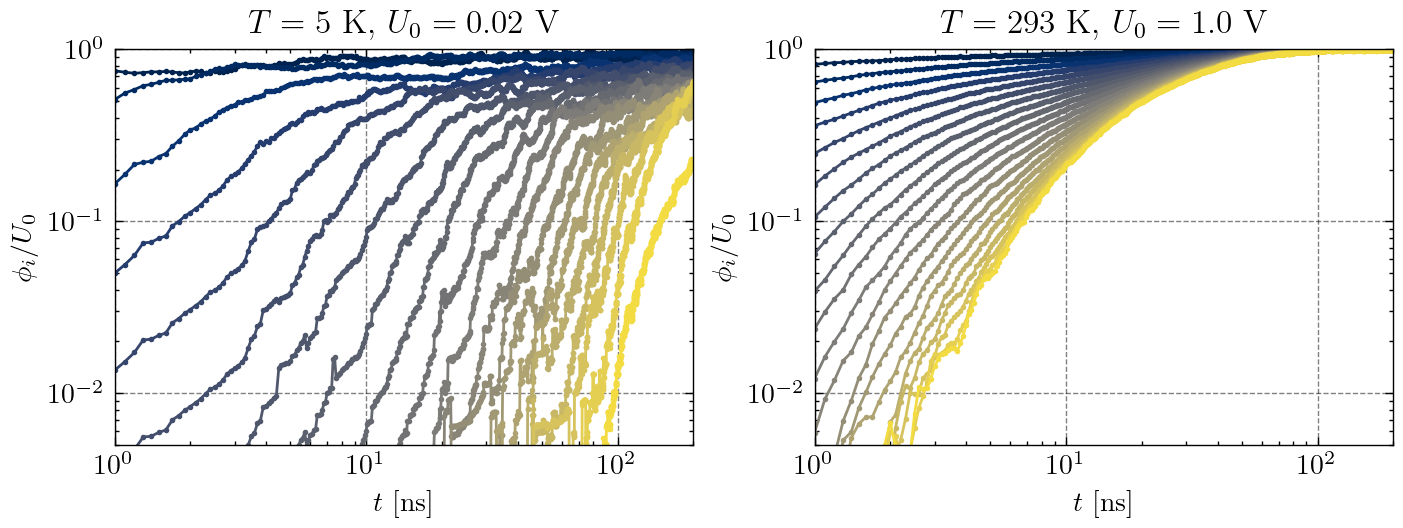

In [138]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
cm  = plt.get_cmap('cividis')
Np  = 20

for i in range(Np):
    ax1.plot(t_vals, pot_cold[Np][f"{i}"].values/U_0_cold, color=cm((i)/Np), marker='.', ms=2)
    p = ax2.plot(t_vals, pot_hot[Np][f"{i}"].values/U_0_hot, color=cm((i)/Np), marker='.', ms=2)

ax1.set_title(f"$T = 5$ K, $U_0 = {U_0_cold}$ V")
ax2.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")
ax1.set_xlabel("$t$ [ns]")
ax1.set_xlim(1,200)
ax2.set_xlim(1,200)
ax1.set_ylim(0.005,1)
ax2.set_ylim(0.005,1)
# ax1.set_xlim(0,50)
# ax2.set_xlim(0,50)
# ax1.set_ylim(0,1)
# ax2.set_ylim(0,1)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
# ax1.set_xlim(0.5,4000)
# ax2.set_xlim(0.5,4000)
# ax1.set_ylim(0,1.0)
# ax2.set_ylim(0,1.0)
# ax1.set_xscale('log')
# ax2.set_xscale('log')
ax1.set_ylabel("$\phi_i / U_0$")
ax1.set_xlabel("$t$ [ns]")
ax2.set_ylabel("$\phi_i / U_0$")
ax2.set_xlabel("$t$ [ns]")

fig.savefig("../plots/dc_input/open_circuit_node_time_series_vs_T.svg", transparent=True)

In [139]:
end_vals    = pot_hot[20].iloc[38000:,:].mean().values
taus        = []
p_th        = 0.63
for i in range(Np):
    j   = np.argwhere(pot_hot[Np].loc[:,f'{i}'].values > p_th*end_vals[i])[0,0]
    tau = t_vals[j]
    taus.append(tau)

Text(0, 0.5, '$\\tau$ [ns]')

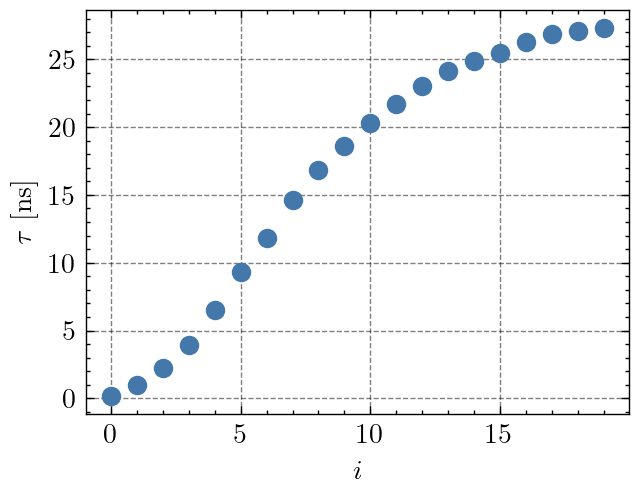

In [141]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(range(Np), taus, 'o')
ax.set_xlabel("$i$")
ax.set_ylabel("$\\tau$ [ns]")
# ax.set_ylim(0,10)
# ax.set_xlim(-1,20)

[0.05412568 1.02740282 0.17482988]
[0.8486502  1.04359241 0.25053736]
[2.69056036 1.04072091 0.33283724]
[5.19698842 1.03973923 0.40877529]
[7.78693352 1.03138726 0.48963021]
[10.28801846  1.02328281  0.56796684]
[12.64805104  1.01494102  0.64823196]
[14.66157486  1.00374548  0.73017314]
[16.35807105  0.99091822  0.81479374]
[17.78210483  0.97752363  0.89906419]
[19.01250911  0.96401038  0.98521287]
[19.92464102  0.94809561  1.07581753]
[20.63110785  0.93183371  1.16613032]
[21.29486356  0.91980571  1.24819168]
[21.87502366  0.90947369  1.32216256]
[22.27171741  0.89910812  1.39284325]
[22.57202332  0.89050252  1.44951407]
[22.77331632  0.88308683  1.49879014]
[23.00097565  0.88063531  1.52566227]
[23.10746999  0.87884743  1.54020962]


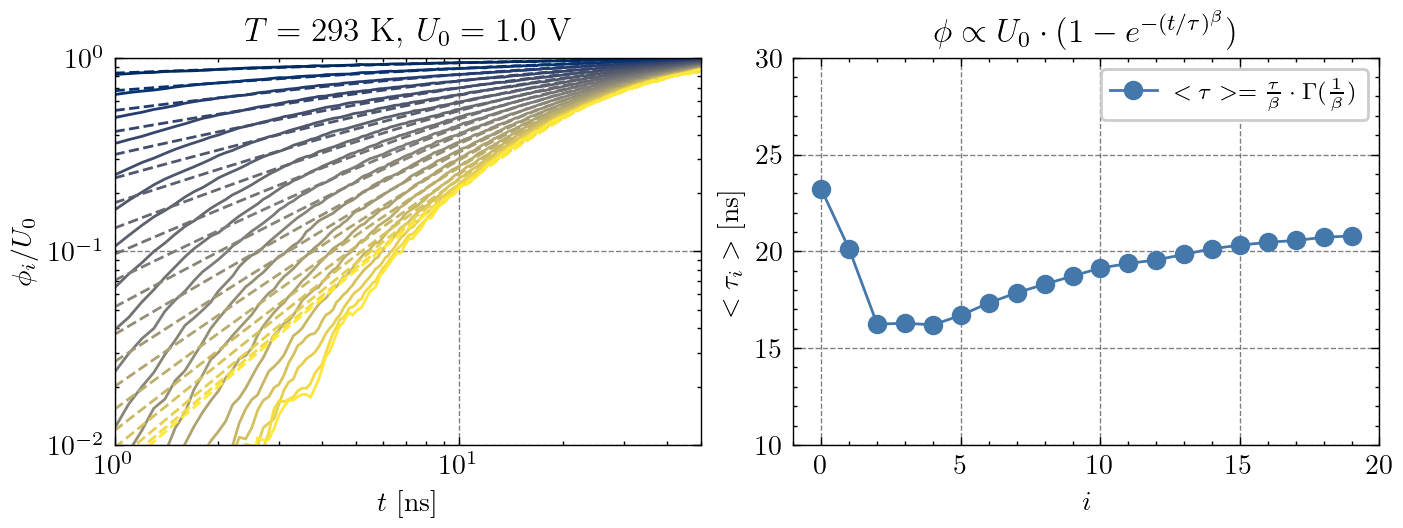

In [148]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax      = fig.add_subplot(1,2,1)
cm      = plt.get_cmap('cividis')
taus    = []
taus1   = []
taus2   = []
betas   = []
starts  = [10,10,10,10,20,20,20,20,30,30,30,30,40,40,40,40,50,50,50,50]
starts  = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]

for i in range(Np):
    x, y    = t_vals[starts[i]:500], pot_hot[Np][f"{i}"].values[starts[i]:500]/U_0_hot
    p,c     = curve_fit(stretched_saturation_curve, x, y, maxfev=10000, p0=[1,1,1], bounds=[(0,0,0),(50,2,2)])#, p0=[1,5,1.0,0.0,0.0], bounds=[(0,0,0,0,0),(10,10,1,2,2)])
    taus.append(p[0])
    taus1.append(p[0])
    taus2.append(p[1])
    betas.append(p[2])
    print(p)

    ax.plot(x, y, color=cm((i+1)/Np), ms=4)#, marker='.')
    ax.plot(x, stretched_saturation_curve(x, *p), color=cm((i+1)/Np), ls='--')

tau = gamma(1/np.array(betas))*np.array(taus)/np.array(betas)
ax.set_xlim(1,50)
# ax.set_ylim(0.001,1)
ax.set_ylim(0.01,1)
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0_hot}$ V")

ax  = fig.add_subplot(1,2,2)
ax.plot(range(Np), tau, 'o-', label='$<\\tau> = \\frac{\\tau}{\\beta} \cdot \Gamma(\\frac{1}{\\beta})$')
# ax.plot(range(Np), taus1, 'o-', label='$\\tau_1$')
# ax.plot(range(Np), taus2, 'o-', label='$\\tau_2$')
ax.set_ylabel('$<\\tau_i>$ [ns]')
ax.set_xlabel("$i$")
ax.set_ylim(10,30)
ax.set_xlim(-1,20)
ax.set_title("$\phi \propto U_0 \cdot (1 - e^{-(t/\\tau)^{\\beta}})$")
ax.legend(fontsize='small')

fig.savefig("../plots/dc_input/open_circuit_room_temp_fit.svg", transparent=True)

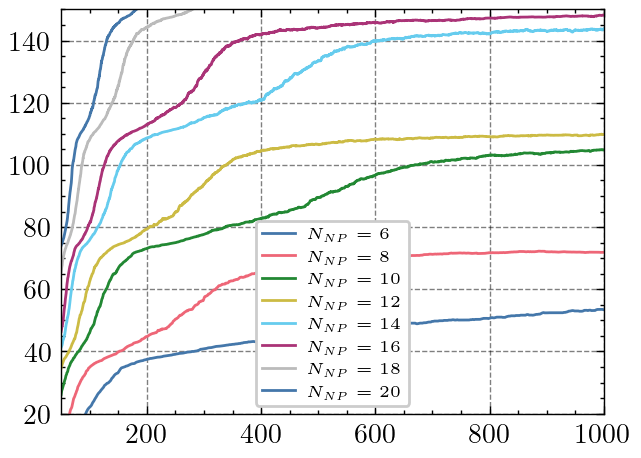

In [4]:
taus    = [21,10.4,5.6,3.5,2.4,1.8,1.3,1]
p, c    = curve_fit(pot_law, np.array(N_vals[2:]), taus)

plt.figure(dpi=200)
for i, N in enumerate(N_vals[2:]):
    plt.plot(t_vals*taus[i], data_string[N]['Current'].values*1000, label='$N_{NP} = '+f'{N}$')

plt.xlim(50,1000)
plt.ylim(20,150)
plt.legend(fontsize='xx-small')

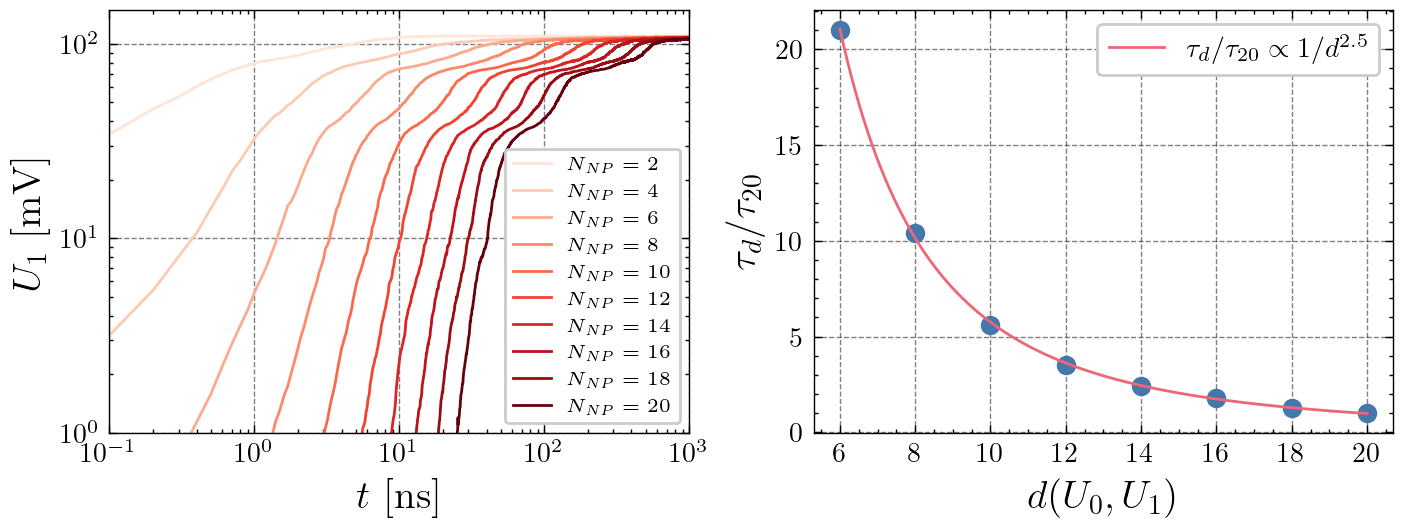

In [18]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('Reds')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i+1)/len(N_vals)))

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,1000)
ax.set_xscale('log')
ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals[2:]), taus, 'o')
ax.plot(np.linspace(N_vals[2],N_vals[-1],1000), func(np.linspace(N_vals[2],N_vals[-1],1000),*p), label="$\\tau_d / \\tau_{20} \propto 1/d^{"+f"{-np.round(p[1],1)}"+"}$")
ax.set_ylabel("$\\tau_{d} / \\tau_{20}$", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals[2:])
ax.legend()

fig.savefig("../plots/string_time_scale_vs_system_size.svg", transparent=True)
fig.savefig("../plots/string_time_scale_vs_system_size.pdf", transparent=False)

In [6]:
taus    = []
tau_m   = []
params  = []
covs    = []

for i, N in enumerate(N_vals):
    x_fit   = t_vals.copy()
    y_fit   = data_string[N]['Current'].values*1000
    # p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,0,0),(500,120,2)])
    p, cov  = curve_fit(saturation_cuve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,80,0),(500,120,20)])
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    tau_m.append(p[0]/p[2] * gamma(1 / p[2]))
    
params

[array([1.60015509e+00, 1.03222185e+02, 3.38248978e-18]),
 array([6.87494356e+00, 1.06505458e+02, 1.86541772e-15]),
 array([1.61888535e+01, 1.03320463e+02, 5.62083227e-19]),
 array([3.42083950e+01, 1.03001236e+02, 1.36004593e-23]),
 array([6.47660070e+01, 1.03127269e+02, 3.62676747e-25]),
 array([1.01835044e+02, 1.02259691e+02, 1.91749288e-26]),
 array([1.48732338e+02, 1.01774407e+02, 3.12229083e-25]),
 array([2.06097830e+02, 1.01184761e+02, 5.32583098e-26]),
 array([2.74897536e+02, 1.00287984e+02, 3.72935542e-24]),
 array([3.43525165e+02, 9.91502037e+01, 2.69950599e-23])]

ValueError: x and y must have same first dimension, but have shapes (10,) and (8,)

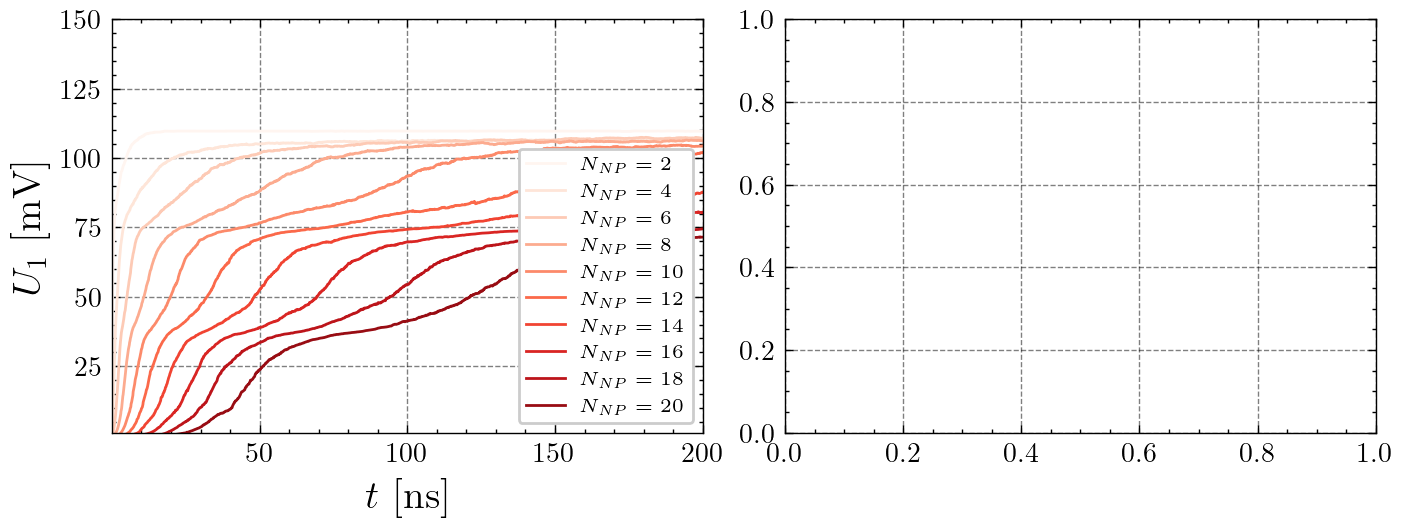

In [124]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('Reds')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i)/len(N_vals)))
    # pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', marker=ms[i%len(ms)], markevery=(20,100), ls='')
    # ax.plot(t_vals, stretched_saturation_curve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.plot(t_vals, saturation_cuve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,200)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, 'o')
ax.plot(np.array(N_vals), 0.26*np.array(N_vals)**2.4)
ax.set_ylabel("$\\tau$ [ns]", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals)
# ax.set_ylim(0,40)
ax.set_xscale('log')
ax.set_yscale('log')

# fig.savefig("../plots/string_time_scale_vs_system_size.svg", transparent=True)
# fig.savefig("../plots/string_time_scale_vs_system_size.pdf", transparent=False)

## @ 293K

In [32]:
taus    = []
tau_m   = []
params  = []
covs    = []

for i, N in enumerate(N_vals):
    x_fit   = t_vals.copy()
    y_fit   = data_string[N]['Current'].values*1000
    # p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,0,0),(500,120,2)])
    p, cov  = curve_fit(saturation_cuve, x_fit, y_fit, p0=[10,100,1.0], bounds=[(0,80,0),(500,120,20)])
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    tau_m.append(p[0]/p[2] * gamma(1 / p[2]))
    
params

[array([3.60208636e-01, 9.99983951e+01, 2.70140781e-14]),
 array([1.30473252e+00, 1.00080876e+02, 1.38410236e-02]),
 array([ 2.31365925, 99.89964599,  0.18774591]),
 array([ 4.24694063, 99.9524589 ,  0.42656966]),
 array([  5.82758871, 100.23118775,   1.00917875]),
 array([ 7.42061568, 99.90728945,  1.56537125]),
 array([ 14.41197854, 100.14512246,   1.23286686]),
 array([13.72309518, 99.75983272,  2.30518612]),
 array([ 18.2560149 , 100.21237258,   1.99005654]),
 array([25.19781029, 99.76907112,  3.68441668])]

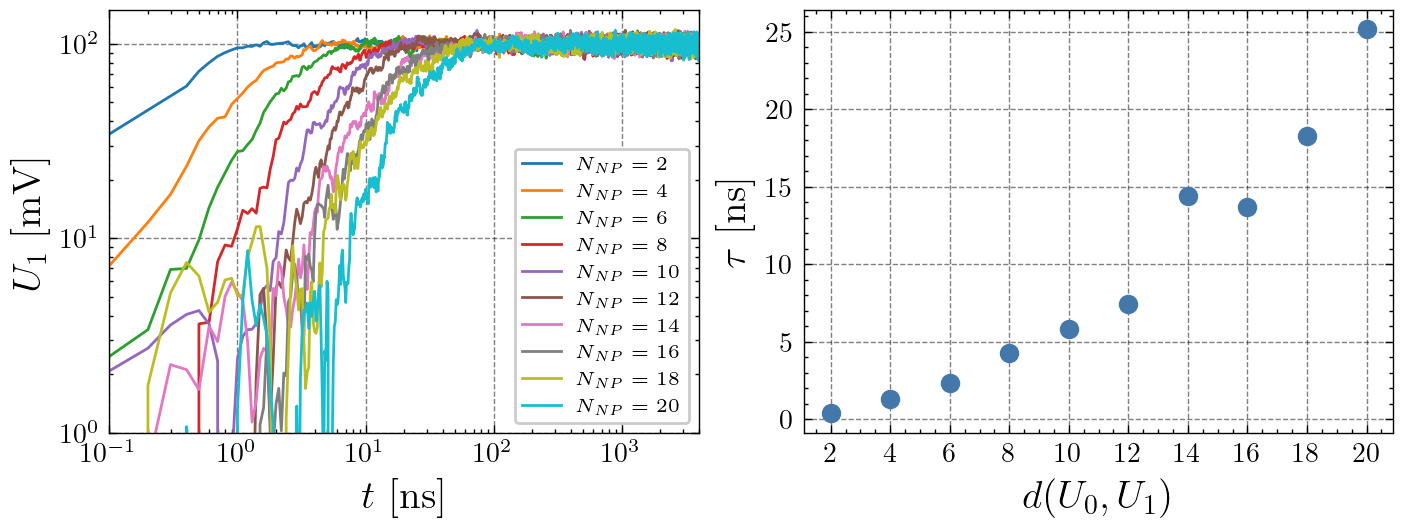

In [35]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']
cm  = plt.get_cmap('tab20')

for i, N in enumerate(N_vals):

    y_val   = data_string[N]['Current'].values*1000
    y_val_e = data_string[N]['Error'].values*1000
    pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', c=cm((i)/len(N_vals)))
    # pp      = ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N}$', marker=ms[i%len(ms)], markevery=(20,100), ls='')
    # ax.plot(t_vals, stretched_saturation_curve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.plot(t_vals, saturation_cuve(t_vals,*params[i]), c=pp[0].get_color())
    # ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_1$ [mV]", fontsize='x-large')
ax.set_xlabel("$t$ [ns]", fontsize='x-large')
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=1)
ax.set_ylim(1,150)
ax.set_xlim(0.1,4000)
ax.set_xscale('log')
ax.set_yscale('log')

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, 'o')
ax.set_ylabel("$\\tau$ [ns]", fontsize='x-large')
ax.set_xlabel("$d(U_0,U_1)$", fontsize='x-large')
ax.set_xticks(N_vals)

fig.savefig("../plots/string_time_scale_vs_system_size_room_temp.svg", transparent=True)
fig.savefig("../plots/string_time_scale_vs_system_size_room_temp.pdf", transparent=False)

In [1]:
path    = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/time_scale/"
N_vals  = [3,5,7,9,11,13]
data    = {N : pd.read_csv(f"{path}Nx={N}_Ny={N}_Nz=1_Ne=8.csv") for N in N_vals}
states  = pd.read_csv(f"{path}mean_state_Nx=11_Ny=11_Nz=1_Ne=8.csv")
x_val   = data[5]['E0'].values*1000
t_val   = np.arange(len(x_val))*1e-10*1e9

NameError: name 'pd' is not defined

In [195]:
taus    = []
params  = []
covs    = []
starts  = len(N_vals)*[0]
stops   = len(N_vals)*[5000]

for i, N in enumerate(N_vals):
    x_fit   = t_vals[starts[i]:stops[i]]
    y_fit   = data[N]['Current'].values[starts[i]:stops[i]]*1000
    p, cov  = curve_fit(stretched_saturation_curve, x_fit, y_fit, p0=[10,20,0], bounds=((0,0,0),(200,30,2)))
    taus.append(p[0])
    params.append(p)
    covs.append(np.sqrt(cov[0,0]))
    
params

[array([ 1.81094987, 10.22819503,  0.80748377]),
 array([3.63031915, 8.29002692, 1.15052751]),
 array([10.64988641,  9.33251991,  1.09799198]),
 array([29.63764537, 13.22357227,  1.17027035]),
 array([68.81264448, 25.9804675 ,  1.82999042]),
 array([128.50547546,  27.69472734,   1.53167537])]

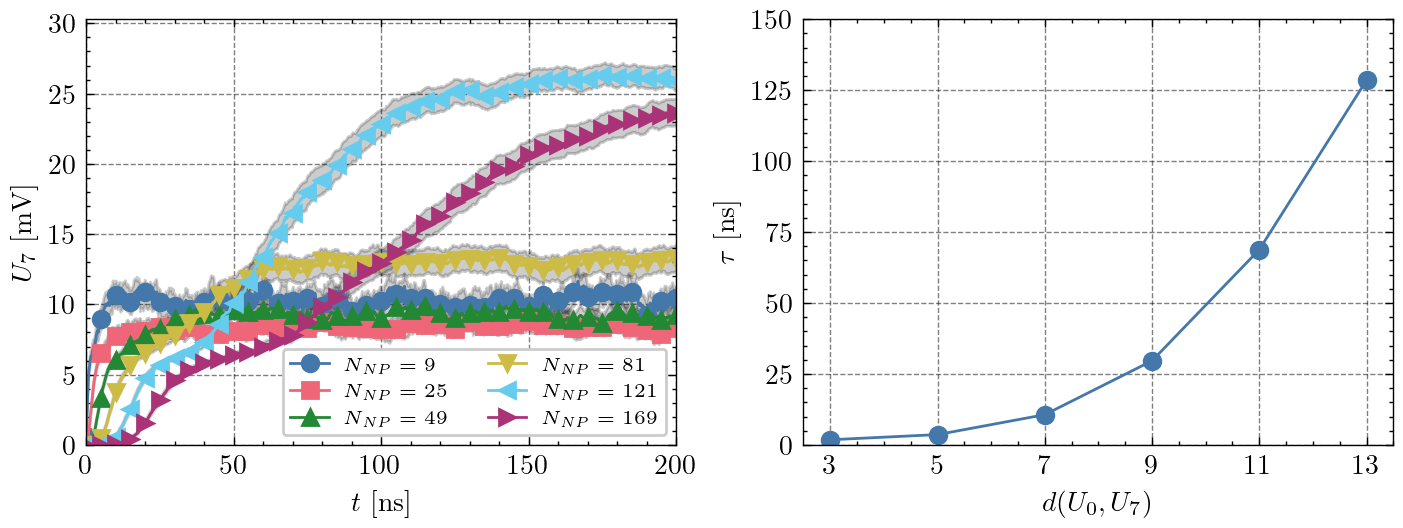

In [200]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ms  = ['o','s','^','v','<','>']

for i, N in enumerate(N_vals):

    y_val   = data[N]['Current'].values*1000
    y_val_e = data[N]['Error'].values*1000
    ax.plot(t_vals, y_val, label='$N_{NP} = '+f'{N**2}$', marker=ms[i%len(ms)], markevery=(50))
    ax.fill_between(t_vals, y_val-y_val_e, y_val+y_val_e, color='black', alpha=0.2)

ax.set_ylabel("$U_7$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax.legend(frameon=True, loc='lower right', fontsize='x-small', ncol=2)
ax.set_xlim(0,200)
ax.set_ylim(0)

ax  = fig.add_subplot(1,2,2)
ax.plot(np.array(N_vals), taus, '-o')
ax.set_ylabel("$\\tau$ [ns]")
ax.set_xlabel("$d(U_0,U_7)$")
ax.set_xticks(N_vals)
ax.set_ylim(0,150)

fig.savefig("../plots/network_time_scale_vs_system_size.svg", transparent=True)
fig.savefig("../plots/network_time_scale_vs_system_size.pdf", transparent=False)

In [214]:
[i*11+11//2 for i in range(11)] + [121]

[5, 16, 27, 38, 49, 60, 71, 82, 93, 104, 115, 121]

In [213]:
11*11

121

In [218]:
states_string

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.045312,0.015904,0.004412,0.001203,0.000328,0.000089,0.000024,0.000007,0.000002,4.936670e-07,1.347624e-07,3.742445e-08,1.272531e-08
1,0.057602,0.026976,0.008983,0.002496,0.000680,0.000185,0.000051,0.000014,0.000004,1.024357e-06,2.796315e-07,7.765559e-08,2.640497e-08
2,0.065364,0.034964,0.014120,0.004286,0.001168,0.000318,0.000087,0.000024,0.000006,1.758922e-06,4.801547e-07,1.333423e-07,4.533993e-08
3,0.070252,0.040504,0.019233,0.006894,0.001949,0.000531,0.000145,0.000039,0.000011,2.934340e-06,8.010234e-07,2.224497e-07,7.563884e-08
4,0.072698,0.045456,0.023894,0.009730,0.002951,0.000805,0.000219,0.000060,0.000016,4.443235e-06,1.212925e-06,3.368377e-07,1.145338e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.102055,0.087345,0.098696,0.086763,0.097898,0.086491,0.093324,0.086367,0.083075,9.727145e-02,8.570426e-02,9.701321e-02,8.177111e-02
4995,0.102055,0.087345,0.098696,0.086763,0.097898,0.086491,0.093324,0.086367,0.083075,9.727145e-02,8.570426e-02,9.701321e-02,8.177111e-02
4996,0.102055,0.087343,0.098688,0.086732,0.097928,0.086499,0.093326,0.086367,0.083076,9.727150e-02,8.570427e-02,9.701322e-02,8.177111e-02
4997,0.102055,0.087343,0.098688,0.086732,0.097928,0.086499,0.093326,0.086367,0.083076,9.727150e-02,8.570427e-02,9.701322e-02,8.177111e-02


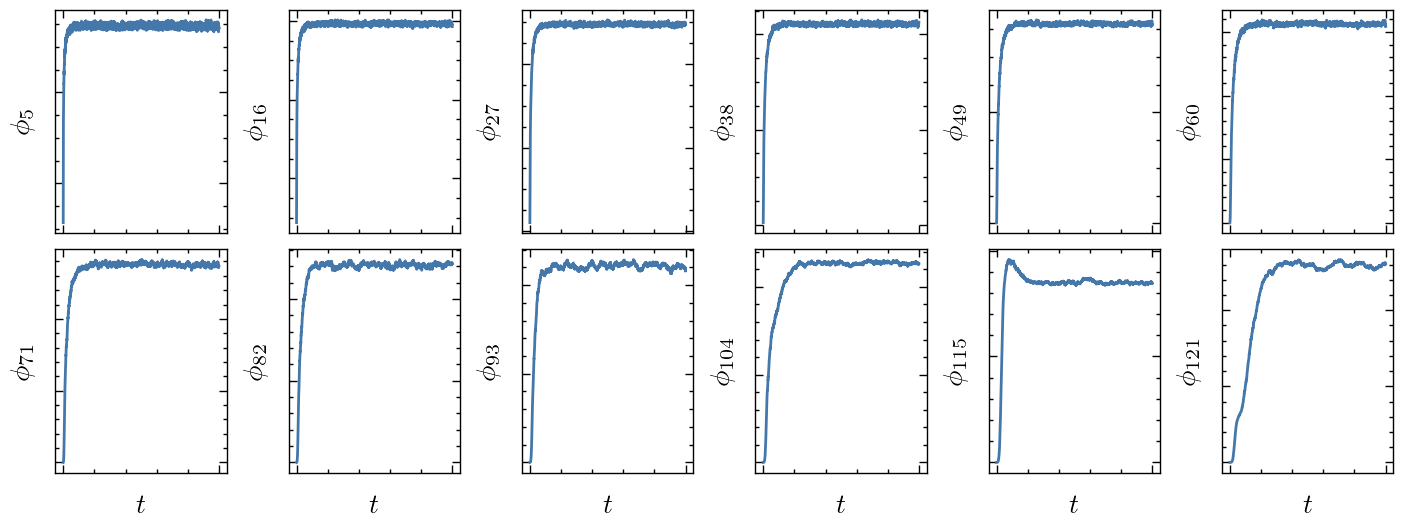

In [235]:
i_np    = [i*11+11//2 for i in range(11)] + [121]
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)

for j, i in enumerate(i_np):

    ax  = fig.add_subplot(2,6,j+1)
    y   = states[f"{i}"].values*1000

    ax.plot(t_vals, y)
    ax.set_ylabel("$\phi_{"f'{i}'+"}$")
    ax.set_yticklabels("")
    ax.set_xticklabels("")
    ax.grid(False)

    if j > 5:
        ax.set_xlabel("$t$")
    
fig.savefig("../plots/network_states.svg", transparent=True)
fig.savefig("../plots/network_states.pdf", transparent=False)

---